# Mixed Linear Models
Try using statsmodels for fitting mixed linear models to the UCadmit data from "Statistical Rethinking"
and see if we get equivalent results to PyMC.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

In [3]:
import os
from pathlib import Path
n_devices = 16
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(n_devices)
os.environ['JAX_PLATFORMS'] = 'cpu'  # BlackJAX NUTS sampler seems to have issues with JAX
import jax
import jax.numpy as jnp

# Statsmodels Tests for BinomialBayesMixedGLM

In [4]:
np.random.seed(8767)
n = 200
m = 20
data = pd.DataFrame({"Year": np.random.uniform(0, 1, n),
                     "Village": np.random.randint(0, m, n)})
data['year_cen'] = data['Year'] - data.Year.mean()

In [5]:
# Binomial outcome
lpr = np.random.normal(size=m)[data.Village]
lpr += np.random.normal(size=m)[data.Village] * data.year_cen
y = (np.random.uniform(size=n) < 1 / (1 + np.exp(-lpr)))
data["y"] = y.astype(int)

In [6]:
print(data.head())

       Year  Village  year_cen  y
0  0.492027        3 -0.034971  0
1  0.640511        5  0.113514  0
2  0.309179       11 -0.217818  0
3  0.284310        8 -0.242688  1
4  0.187762        6 -0.339236  1


In [7]:
# These lines should agree with the example in the class docstring.
random = {"a": '0 + C(Village)', "b": '0 + C(Village)*year_cen'}
model = BinomialBayesMixedGLM.from_formula(
             'y ~ year_cen', random, data)
result = model.fit_vb()

In [8]:
print(result.summary())

               Binomial Mixed GLM Results
          Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------
Intercept    M    -0.1784   0.1562                      
year_cen     M     0.1085   0.5803                      
a            V    -0.0792   0.1565 0.924   0.676   1.263
b            V    -1.4086   0.1131 0.244   0.195   0.307
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard
deviations


# University of Berkeley Admissions Data

In [9]:
data_dir = Path.home() / 'Work' / 'Data' / 'statistical_rethinking'

In [10]:
cache_file = data_dir / 'ucadmit_long.csv'
src_url = 'https://github.com/rmcelreath/rethinking/raw/refs/heads/master/data/UCBadmit_long.csv'
try:
    df = pd.read_csv(cache_file)
    print('Reading from cache')
except FileNotFoundError:
    print('Downloading ucadmit_long.csv')
    df = pd.read_csv(src_url, sep=';').rename(columns={'applicant.gender': 'gender'})
    df.to_csv(cache_file, index=False)


Reading from cache


In [11]:
df = df.assign(
    dept_idx=lambda x: pd.Categorical(x.dept, sorted(x.dept.unique())).codes,
    gender_idx=lambda x: pd.Categorical(x.gender, sorted(x.gender.unique())).codes,
)
df.head()

,dept,gender,admit,dept_idx,gender_idx
0,A,male,1,0,1
1,A,male,1,0,1
2,A,male,1,0,1
3,A,male,1,0,1
4,A,male,1,0,1


In [12]:
random_dept_intercept = {"a": '0 + C(dept) ','b': '0 + gender_idx'}  # p399 table R code 13.18 output
random_dept_and_slope = {"a": '0 + C(dept)', "b": '0 + C(dept):gender_idx'}  # p402 Fig 13.6

model_1 = BinomialBayesMixedGLM.from_formula('admit ~ 1', random_dept_intercept, df)
result_1 = model_1.fit_map()

model_2 = BinomialBayesMixedGLM.from_formula('admit ~ 1', random_dept_and_slope, df)
result_2 = model_2.fit_map()

## Results for Intercept Only Model
Compare with Table p399 Statistical Rethinking 2016

In [13]:
print(result_1.fe_mean)

[-0.56482498]


In [14]:
print(result_1.random_effects())

                Mean        SD
C(dept)[A]  1.233491  0.441616
C(dept)[B]  1.186944  0.443981
C(dept)[C] -0.019078  0.441392
C(dept)[D] -0.052545  0.441705
C(dept)[E] -0.491831  0.444815
C(dept)[F] -2.025780  0.455320
gender_idx -0.090365  0.079288


# Intercept and Slope Model
Compare with figure 13.6

In [15]:
print(result_2.random_effects())

                           Mean        SD
C(dept)[A]             1.584262  0.536260
C(dept)[B]             1.090501  0.500911
C(dept)[C]            -0.114589  0.474343
C(dept)[D]            -0.097610  0.474222
C(dept)[E]            -0.591262  0.479577
C(dept)[F]            -2.051216  0.489345
C(dept)[A]:gender_idx -0.517172  0.357571
C(dept)[B]:gender_idx -0.019951  0.219331
C(dept)[C]:gender_idx  0.094601  0.129288
C(dept)[D]:gender_idx -0.061758  0.131308
C(dept)[E]:gender_idx  0.120615  0.170118
C(dept)[F]:gender_idx -0.107842  0.212035


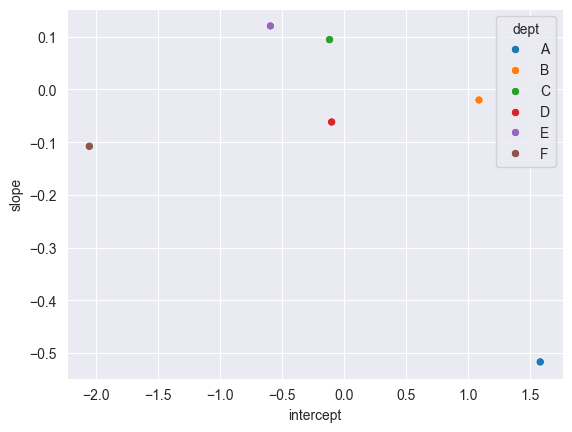

In [18]:
# Figure 13.6
df_p = pd.DataFrame(
    {
        'intercept': result_2.random_effects('a')['Mean'].values,
        'slope': result_2.random_effects('b')['Mean'].values,
        'dept': 'A B C D E F'.split(' ')
    }
)
_ = sns.scatterplot(df_p, x='intercept', y='slope', hue='dept')